# Travail pratique 1 - IFT 3700
##### Remis le 22 novembre 2020 par Rym Bach et Laurier Lavoie-Giasson
## Introduction
Dans le cadre de ce travail, on s'intéresse à la précision des différentes techniques de classification vues en classe, et de comparer son niveau en utilisant la distance euclidienne ainsi que [...]
## Code
### Installation des packages nécessaires

In [1]:
import sys
!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install tqdm scikit-image

Defaulting to user installation because normal site-packages is not writeable


### Chargement et prétraitement des jeux de données d'entraînement et de tests

In [2]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA

CONST_N_DIM=784

def preprocessing(aX, an_dimensions=CONST_N_DIM):
    #cette fonction sera utilisée pour le prétraitement des données du jeu de données.
    
    ret_val = np.array([np.round(np.divide(aX[i], 255.0)) for i in tqdm(range(len(aX)))])
    #application de PCA pour la réduction de dimensionalité
    #pca = PCA(n_components=an_dimensions)
    #ret_val = pca.fit_transform(X_rounded)
    return ret_val
    
def readMNIST(afilename, an_dimensions=CONST_N_DIM):
    #cette fonction lit le fichier de MNIST à l'emplacement fourni et retourne le jeu de
    #données sur lequel on a appliqué la fonction de prétraitement
    data = open(afilename)
    csv_file = csv.reader(data)
    data_points = [row for row in csv_file] #pour enlever les headers
    data_points.pop(0)
    #valeurs Y de taille 1 (labels)
    print("Extraction des labels pour", afilename)
    Y = np.array([int(data_points[i][0]) for i in tqdm(range(len(data_points)))])
    
    #vecteurs X de taille 784 (arrondis à l'entier le plus près)
    print("Extraction des points de données pour", afilename)
    X = np.array([[int(j) for j in data_points[i][1:]] for i in tqdm(range(len(data_points)))])
    X = X.reshape((len(Y),784))
    
    #on retourne un tuple avec les vecteurs x et les valeurs y
    return (preprocessing(X, an_dimensions),Y)

XY_train = readMNIST('mnist_train.csv', CONST_N_DIM)
X_train = XY_train[0]
Y_train = XY_train[1]

XY_test = readMNIST('mnist_test.csv', CONST_N_DIM)
X_test = XY_test[0]
Y_test = XY_test[1]

  2%|▏         | 1390/60000 [00:00<00:04, 13887.63it/s]

Extraction des labels pour mnist_train.csv
Extraction des points de données pour mnist_train.csv


 16%|█▌        | 1559/10000 [00:00<00:00, 15582.36it/s]

Extraction des labels pour mnist_test.csv
Extraction des points de données pour mnist_test.csv


100%|██████████| 10000/10000 [00:00<00:00, 182842.79it/s]


### _Sanity Check_
Ici on regarde si les données sont encore "saines", c'est à dire si on peut afficher la première lettre du jeu de données

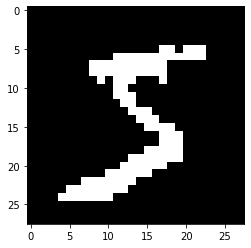

In [3]:
plt.imshow(X_train[0].reshape((28,28)), cmap="gray")
plt.show()

### Mise en place de la métrique à utiliser

Soit $X = \begin{pmatrix}x_{11} & ... & x_{1n}\\ ... & ... & ... \\ x_{n1} & ... & x_{nn}\end{pmatrix}$, le caractère en question. On calculera d'abord $M_{00}, M_{01}$ et $M_{10}$.

\begin{align}
    M_{ij} = \sum_{k=1}^{d_1}\sum_{\ell}^{d_2}x_{k\ell}k^i\cdot\ell^j
\end{align}

On calculera alors le centroïde de l'image $\{\bar{x},\bar{y}\} = \{\frac{M_{10}}{M_{00}}, \frac{M_{01}}{M_{00}}\}$, suivi des moments centraux $\mu_{00}, \mu_{20}, \mu_{02}, \mu_{11}, \mu_{30}, \mu_{03}, \mu_{21}$ et $\mu_{12}$

\begin{align}
    \mu_{ij} = \sum_{k=1}^{d_1}\sum_{\ell=1}^{d_2}x_{k\ell}\cdot(k-\bar{x})^i\cdot(\ell−\bar{y})^j)
\end{align}

Pour finir, on calculera la similarité des points en comparant la distance euclidienne entre les vecteurs contenant leurs moments invariants $\eta_{20}, \eta_{02}, \eta_{11}, \eta_{30}, \eta_{03}, \eta_{21}$ et $\eta_{12}$.

\begin{align}
    \eta_{ij} = \frac{\mu_{ij}}{\mu_{00}^{(1+\frac{i+j}{2})}}
\end{align}

In [4]:
from skimage.measure import moments, moments_central

#matrice des exposants à appliquer à mu00, pour accélérer les calculs en les faisant faire en série par Numpy
muij_exponents=np.array([[1+(i+j)/2.0 for j in range(4)] for i in range(4)])
print(muij_exponents)

#matrice des facteurs de eta_ij, pour enlever les valeurs "non désirées" à la matrice "finale" des eta_ij
eta_ij_selected=np.array([
    [0,0,1,1],
    [0,1,1,0],
    [1,1,0,0],
    [1,0,0,0]
])

#fonction qui calcule eta_ij pour un vecteur X de taille 784 donné
def compute_eta_ij(ax):
    x = ax.reshape((28,28))
    m = moments(x)
    centroid = (m[1,0]/m[0,0], m[0,1]/m[0,0])
    mu = moments_central(x, centroid)
    #print(mu[0,0])
    #on multiplie par eta_ij_selected, pour soustraire les valeurs nécessaires
    eta = np.multiply(mu, np.power(mu[0,0], muij_exponents))
    return np.array([eta[2,0], eta[0,2], eta[1,1], eta[3,0], eta[0,3], eta[2,1], eta[1,2]])

#on définit la fonction de similarité à utiliser
def moment_distance(ax_1, ax_2):
    return np.linalg.norm(compute_eta_ij(ax_1)-compute_eta_ij(ax_2))

[[1.  1.5 2.  2.5]
 [1.5 2.  2.5 3. ]
 [2.  2.5 3.  3.5]
 [2.5 3.  3.5 4. ]]


### Inconvénient lors de l'utilisation de cette métrique de façon conventionnelle - Complexité
En ne faisant que spécifier la métrique dans le contructeur des différents classificateurs, on augmente drastiquement la complexité. En effet, pour les $n^2$ paires de points, pour calculer la matrice des distances entre, on effectue 1 appel de la fonction compute_eta_ij par point, pour un total de 2n^2. Comme la matrice est symétrique, on peut considérer que l'on appelle $n^2$ fois la fonction. Cependant, la complexité du calcul des $\eta_{ij}$ est bien plus grande que celle de la distance euclidienne! Il convient donc d'adapter la méthode de calcul pour réduire la complexité.

### Solution - _precomputation_
Évidemment, une fois que l'on a exécuté compute_eta_ij pour un point du jeu de données, on peut stocker la valeur de retour dans une liste. Puisque la métrique proposée utilise la distance euclidienne à l'intérieur, on peut donc simplement faire un précalcul des $\eta_{ij}$ nécessaires pour la métrique, et les stocker dans une liste. Cela nous permettra de classifier le jeu de données de la même façon que l'on l'aurait fait dans le jeu de données d'origine.

Par contre, pour pouvoir classer une donnée, on devra d'abord effectuer la transformation pour obtenir les $\eta_{ij}$.

La cellule ci-dessous effectue le précalcul nécessaire à la métrique.

In [5]:
def precompute_eta_ij(aX):
    return np.array([compute_eta_ij(x) for x in tqdm(aX)])

print("précalcul des eta_ij pour le jeu de données d'entraînement")
X_train_etaij = precompute_eta_ij(X_train)
print("précalcul des eta_ij pour le jeu de données de tests")
X_test_etaij = precompute_eta_ij(X_test)

  5%|▌         | 3032/60000 [00:00<00:03, 14966.12it/s]

précalcul des eta_ij pour le jeu de données d'entraînement


 16%|█▌        | 1555/10000 [00:00<00:00, 15540.71it/s]

précalcul des eta_ij pour le jeu de données de tests


100%|██████████| 10000/10000 [00:00<00:00, 15385.07it/s]


### Classification en utilisant l'algorithme K-médoïdes


L'algorithme des k-médoïdes est un algorithme de partitionnement plus robuste vis-à-vis des données aberrantes que celui des k-moyennes. L'algorithme des k-médoïdes minimise l'erreur quadratique moyenne qui est la distance entre les points de la classe et le point central, qui est un point du jeu de données. On va donc l'appliquer sur nos données 

In [17]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedoids import kmedoids 


 
#cette méthode utilisée pour classifier les données est la bonne. Il faut 
def classify_fmedoide(X_train, Y_train):
    scores = []
    k_range = range(2,15)
    for k in k_range:
        y_pred = KMeans(n_clusters=k).fit_predict(X_train)
        scores.append(silhouette_score(X_train, y_pred))

    plt.plot(k_range, scores)
    plt.xlabel('k')
    plt.ylabel('Score silhouette')
    plt.title('Score silhouette en fonction de k')

return np.array([k_range, scores])

#cette fonction ne semble pas nécessaire
def kmedoide_Euclidienne () :               
    MatrixDeucli = euclidean_distances(X_train)
    tab =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    #kmedoidseuclidienne = MatrixDeucli, tab, data_type='distance_matrix')
    kmedoidseuclidienne.process()
    euclidienne_medoids = kmedoidseuclidienne.get_medoids()
    clusters_euclidienne = kmedoidseuclidienne.get_clusters()
    #j'ai réindenté ceci pour que ça "compile"fonctionne bien
    return np.array([euclidienne_medoids,clusters_euclidienne])  

#cette fonction n'est pas nécessaire non plus
def kmedoide_distance ()     :               
    matrixSimi = np.array(copy.deepcopy(Y_train).astype(np.float64)
    tab =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    kmedoidsdistance = kmedoids(matrixSimi, tab, data_type='distance_matrix')
    kmedoidsdistance.process()
    distancemedoids = kmedoidsdistance.get_medoids()
    clustersdistance = kmedoidsdistance.get_clusters()
    #réindentation ici aussi
    return np.array([kmedoidsdistance,clustersdistance]) 

#le travail n'est pas d'implémenter les algorithmes de classification, c'est plutôt d'utiliser ce que
#scikit-learn fournit de pré-construit pour pouvoir faire abstraction de l'algorithme (de présumer que
#l'algorithme fonctionnera, sans se poser de question sur les technicalités de ce qui se passe derrière).
#essaie de regarder des exemples de classification avec KMeans de scikit-learn sur Internet, ça devrait t'aider

SyntaxError: invalid syntax (<ipython-input-17-61990fb90dde>, line 36)

### Classification en utilisant l'algorithme des K plus proches voisins

Ici, pour accélérer le temps de calcul, on utilise le module `multiprocessing`. On démarre des processus pour ne pas être limité par le _Global Interpreter Lock_ de Python.

In [15]:
from multiprocessing import Process
from multiprocessing.sharedctypes import Array
import math
#on va utiliser ici du multi-processing pour travailler autour du GIL de Python,
#on va démarrer plusieurs processus et travailler sur des variables partagées

def fit_and_score(aX_train, aY_train, aX_test, aY_test, ak, aAccuracy_shared_array):
    classifier = KNeighborsClassifier(n_neighbors=ak)
    classifier.fit(aX_train, aY_train)
    aAccuracy_shared_array[ak] = classifier.score(aX_test, aY_test)
    return aAccuracy_shared_array[ak]

def classify_KNN(aX_train, aY_train, aX_test, aY_test, max_neighbors, multi_process=True):
    if multi_process:
        #on crée un tableau partagé de doubles "primitifs" de C pour les résultats
        aX_train_shared=Array('d', aX_train.shape[0]*aX_train.shape[1])
        #on le passe à Numpy pour utilisation à travers l'interface "buffer"
        aX_train_mp=np.frombuffer(aX_train_shared.get_obj()).reshape(aX_train.shape)
        #on copie les valeurs de l'argument dans le tableau partagé
        np.copyto(aX_train_mp, aX_train)
        
        aY_train_shared=Array('d', aY_train.size)
        aY_train_mp=np.frombuffer(aY_train_shared.get_obj())
        np.copyto(aY_train_mp, aY_train)
        
        
        aX_test_shared=Array('d', aX_test.shape[0]*aX_test.shape[1])
        aX_test_mp=np.frombuffer(aX_test_shared.get_obj()).reshape(aX_test.shape)
        np.copyto(aX_test_mp, aX_test)
        
        
        aY_test_shared=Array('d', aY_test.size)
        aY_test_mp=np.frombuffer(aY_test_shared.get_obj())
        np.copyto(aY_test_mp, aY_test)
        
        #initialisation des K impairs
        k_range = range(max_neighbors)
        
        #on crée un tableau partagé de doubles "primitifs" de C pour stocker la précision des modèles
        accuracy_array = Array('d', len(k_range))
        accuracy = np.frombuffer(accuracy_array.get_obj())
        #on initialise les valeurs à zéro
        np.copyto(accuracy, np.zeros(len(k_range)))
        
        processes = []
        
        for k in k_range:
            if k % 2 != 0:
                #spawn un processus pour calculer, qui lira la mémoire partagée
                myprocess=Process(target=fit_and_score, args=(aX_train_mp, aY_train_mp, aX_test_mp, aY_test_mp, k, accuracy))
                processes.append(myprocess)
                myprocess.start()
        for i in tqdm(range(len(processes))):
            myprocess=processes[i]
            #join le processus pour arrêter l'exécution jusqu'à temps que les calculs soient terminés
            myprocess.join()
            del myprocess
        #retourner les paires de K et de précision
        return np.array([np.array(k_range), accuracy])
    else:
        for k in range(max_neighbors):
            if k % 2 != 0:
                classifier = KNeighborsClassifier(n_neighbors=1)
                classifier.fit(aX_train, aY_train)
                print(classifier.score(aX_test, aY_test))
        

resultats_KNN = classify_KNN(X_train[1:10000], Y_train[1:10000], X_test[1:10000], Y_test[1:10000], 15, True)

100%|██████████| 7/7 [02:43<00:00, 23.40s/it] 


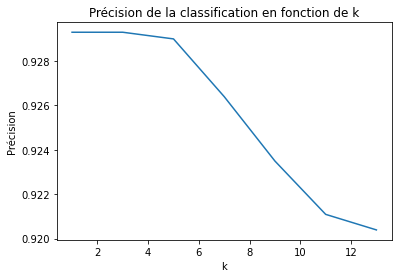

In [20]:
resultats_KNN_filtres = [[],[]]

for i in range(len(resultats_KNN[0])):
    if i % 2 == 1:
        resultats_KNN_filtres[0].append(resultats_KNN[0][i])
        resultats_KNN_filtres[1].append(resultats_KNN[1][i])

resultats_KNN_filtres = np.array(resultats_KNN_filtres)
plt.plot(resultats_KNN_filtres[0], resultats_KNN_filtres[1])
plt.xlabel('k')
plt.ylabel('Précision')
plt.title('Précision de la classification en fonction de k')
plt.show()

On voit ici que la précision est la plus haute lo

In [ ]:
resultats_KNN = classify_KNN(X_train_etaij, Y_train, X_test_etaij, Y_test, 15, False)

### Classification avec K